In [27]:
%pylab inline
import numpy as np
from tqdm import trange
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [28]:
X_train = pd.read_csv("train.csv").drop('label', axis=1).to_numpy()
Y_train = pd.read_csv("train.csv")['label'].to_numpy()

In [29]:
X_train.shape

(42000, 784)

In [30]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class TestNet(torch.nn.Module):
    def __init__(self):
        super(TestNet, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.sm = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sm(self.fc3(x))
        return x

In [31]:
model = TestNet()

In [32]:
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []

In [34]:
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    print(X.shape)
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

loss 0.17 accuracy 0.96:   2%|▏         | 21/1000 [00:00<00:04, 204.45it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.34 accuracy 0.94:   7%|▋         | 67/1000 [00:00<00:04, 213.13it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.18 accuracy 0.95:  11%|█▏        | 114/1000 [00:00<00:03, 221.93it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.19 accuracy 0.91:  16%|█▌        | 161/1000 [00:00<00:03, 224.96it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.15 accuracy 0.95:  21%|██        | 210/1000 [00:01<00:03, 233.05it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.11 accuracy 0.95:  26%|██▌       | 261/1000 [00:01<00:03, 242.14it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.25 accuracy 0.94:  31%|███       | 310/1000 [00:01<00:02, 235.53it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.07 accuracy 0.97:  36%|███▌      | 358/1000 [00:01<00:02, 233.09it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.31 accuracy 0.94:  41%|████      | 406/1000 [00:01<00:02, 231.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.30 accuracy 0.91:  45%|████▌     | 454/1000 [00:02<00:02, 234.26it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.18 accuracy 0.96:  50%|█████     | 504/1000 [00:02<00:02, 236.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.16 accuracy 0.95:  56%|█████▌    | 555/1000 [00:02<00:01, 233.89it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.10 accuracy 0.98:  60%|██████    | 603/1000 [00:02<00:01, 230.64it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.06 accuracy 0.98:  65%|██████▌   | 652/1000 [00:02<00:01, 233.52it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.18 accuracy 0.95:  70%|███████   | 701/1000 [00:03<00:01, 237.60it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.16 accuracy 0.95:  75%|███████▌  | 750/1000 [00:03<00:01, 233.54it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.18 accuracy 0.95:  80%|███████▉  | 798/1000 [00:03<00:00, 234.18it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.18 accuracy 0.95:  85%|████████▍ | 846/1000 [00:03<00:00, 232.00it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.05 accuracy 0.98:  90%|████████▉ | 896/1000 [00:03<00:00, 237.58it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.19 accuracy 0.95:  95%|█████████▍| 946/1000 [00:04<00:00, 236.81it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.15 accuracy 0.95:  99%|█████████▉| 994/1000 [00:04<00:00, 234.07it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

loss 0.20 accuracy 0.93: 100%|██████████| 1000/1000 [00:04<00:00, 233.33it/s]

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])


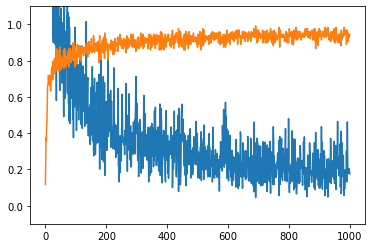

In [23]:
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [8]:
# Loading in real test file
testset = pd.read_csv("test.csv")
testset = torch.Tensor(testset.values)
print(testset.shape)

torch.Size([28000, 784])


In [9]:
#Generate submission file 
f = open("submission.txt", "w")
p = []
for i in range(0, 28000):
    pred = model(testset[i].view(-1, 784))
    f.write(str(i+1) + ',' + str(pred.argmax().numpy()) + '\n')